In [14]:
import tensorflow as tf
import os
import random
import numpy as np
import helpers
import cv2 as cv
import math
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [2]:
seed = 42
np.random.seed = seed

PATCH_SIZE = 80
IMG_CHANNELS = 3
NEW_TRAINING_LEN = 0

TRAIN_PATH_IMAGES = 'training/images/'
TRAIN_PATH_GROUNDTRUTH = 'training/groundtruth/'
NEW_TRAIN_PATH_IMAGES = 'new_training/images/'
NEW_TRAIN_PATH_GROUNDTRUTH = 'new_training/groundtruth/'

TEST_PATH = 'test_set_images/'

train_ids = os.listdir(TRAIN_PATH_IMAGES)
new_train_ids = os.listdir(NEW_TRAIN_PATH_IMAGES)
test_ids = os.listdir(TEST_PATH)

# 25 361 and 64 are how many patches of PATCH_SIZE are in each image
train_len = len(train_ids)*25 + NEW_TRAINING_LEN*361
test_len = len(test_ids)*64

X_train = np.zeros((train_len, PATCH_SIZE, PATCH_SIZE, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((train_len, PATCH_SIZE, PATCH_SIZE, 1), dtype=np.bool_)

In [3]:
print('Resizing training images and masks')
position1 = 0
position2 = 0

# Base training samples
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    imgs = imread(TRAIN_PATH_IMAGES + id_)
    imgs = helpers.split_into_patches(imgs,PATCH_SIZE)
    for img in imgs:
            X_train[position1] = img
            position1 += 1
    masks = imread(TRAIN_PATH_GROUNDTRUTH + id_)
    masks = helpers.split_into_patches(masks,PATCH_SIZE)
    for msk in masks:
            msk = np.expand_dims(msk, axis=2)
            Y_train[position2] = msk
            position2 += 1

# New training samples
for n, id_ in tqdm(enumerate(new_train_ids[:NEW_TRAINING_LEN]), total=NEW_TRAINING_LEN):   
    imgs = imread(NEW_TRAIN_PATH_IMAGES + id_)
    imgs = helpers.split_into_patches(imgs,PATCH_SIZE)
    for img in imgs:
        X_train[position1] = img
        position1 += 1
    masks = imread(NEW_TRAIN_PATH_GROUNDTRUTH + id_)
    masks = helpers.split_into_patches(masks,PATCH_SIZE)
    
    for msk in masks:
        msk = np.expand_dims(msk, axis=2)
        Y_train[position2] = mask
        position2 += 1

Resizing training images and masks


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 88.71it/s]
0it [00:00, ?it/s]


In [4]:
# Test images
X_test = np.zeros((test_len, PATCH_SIZE, PATCH_SIZE, IMG_CHANNELS), dtype=np.uint8)
PATCHES = 64
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    imgs = imread(path + '/' + id_ + '.png')
    imgs = helpers.split_into_patches(imgs,PATCH_SIZE)
    for i, img in enumerate(imgs):
        X_test[n*PATCHES + i] = img

print('Done!')

Resizing test images


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 64.50it/s]

Done!


We pad the test images to be able to make patches of the right size :


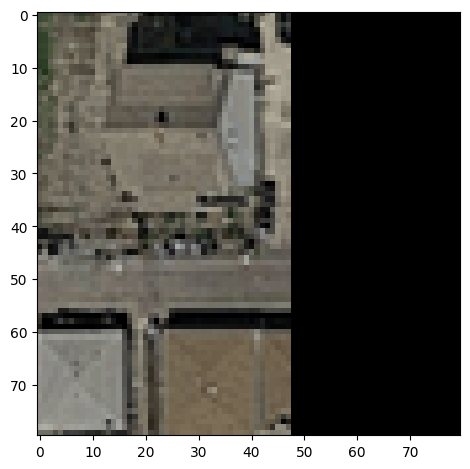

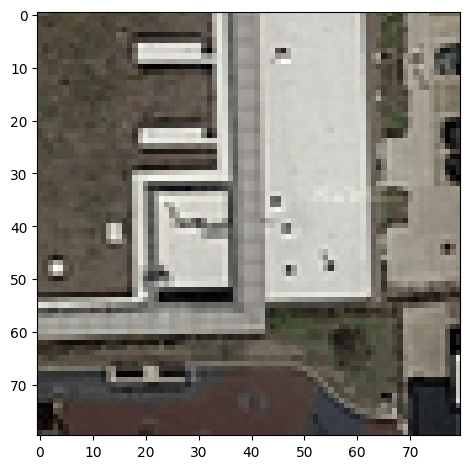

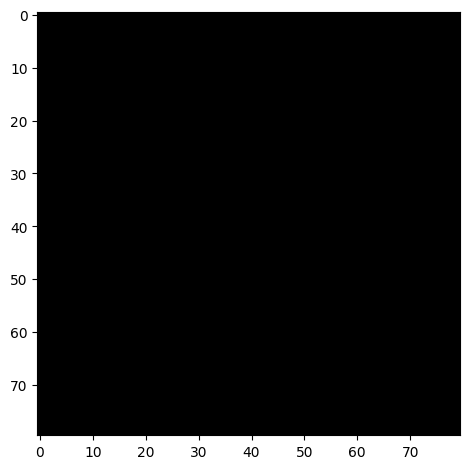

In [5]:
print('We pad the test images to be able to make patches of the right size :')
imshow(imgs[7])
plt.show()

image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [6]:
#Build the model
inputs = tf.keras.layers.Input((PATCH_SIZE, PATCH_SIZE, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 lambda (Lambda)                (None, 80, 80, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 16)   448         ['lambda[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 80, 80, 16)   0           ['conv2d[0][0]']                 
                                                                                              

                                                                                                  
 concatenate_3 (Concatenate)    (None, 80, 80, 32)   0           ['conv2d_transpose_3[0][0]',     
                                                                  'conv2d_1[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 80, 80, 16)   4624        ['concatenate_3[0][0]']          
                                                                                                  
 dropout_8 (Dropout)            (None, 80, 80, 16)   0           ['conv2d_16[0][0]']              
                                                                                                  
 conv2d_17 (Conv2D)             (None, 80, 80, 16)   2320        ['dropout_8[0][0]']              
                                                                                                  
 conv2d_18

In [7]:
################################
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=25, callbacks=callbacks)

####################################

Epoch 1/25
71/71 [==============================] - 41s 527ms/step - loss: 0.5355 - accuracy: 0.7771 - val_loss: 0.5314 - val_accuracy: 0.7488
Epoch 2/25
71/71 [==============================] - 38s 534ms/step - loss: 0.4917 - accuracy: 0.7776 - val_loss: 0.5248 - val_accuracy: 0.7488
Epoch 3/25
71/71 [==============================] - 41s 585ms/step - loss: 0.4558 - accuracy: 0.7776 - val_loss: 0.4589 - val_accuracy: 0.7488
Epoch 4/25
71/71 [==============================] - 41s 571ms/step - loss: 0.4103 - accuracy: 0.7962 - val_loss: 0.4388 - val_accuracy: 0.7494
Epoch 5/25
71/71 [==============================] - 43s 606ms/step - loss: 0.3758 - accuracy: 0.8184 - val_loss: 0.3774 - val_accuracy: 0.8121
Epoch 6/25
71/71 [==============================] - 42s 597ms/step - loss: 0.3370 - accuracy: 0.8456 - val_loss: 0.3681 - val_accuracy: 0.8006
Epoch 7/25
71/71 [==============================] - 43s 606ms/step - loss: 0.2977 - accuracy: 0.8658 - val_loss: 0.3702 - val_accuracy: 0.8084

In [9]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

100/100 [==============================] - 11s 113ms/step


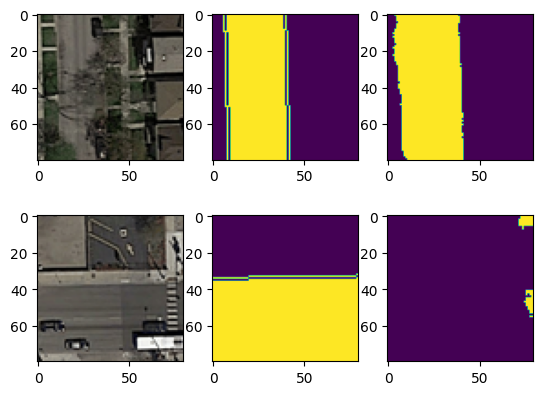

In [10]:
# Perform a sanity check on some random training samples
fig, ax = plt.subplots(2,3)
ix = random.randint(0, len(preds_train_t))
ax[0,0].imshow(X_train[ix])
ax[0,1].imshow(np.squeeze(Y_train[ix]))
ax[0,2].imshow(np.squeeze(preds_train_t[ix]))

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
ax[1,0].imshow(X_train[int(X_train.shape[0]*0.9):][ix])
ax[1,1].imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
ax[1,2].imshow(np.squeeze(preds_val_t[ix]))
plt.show()

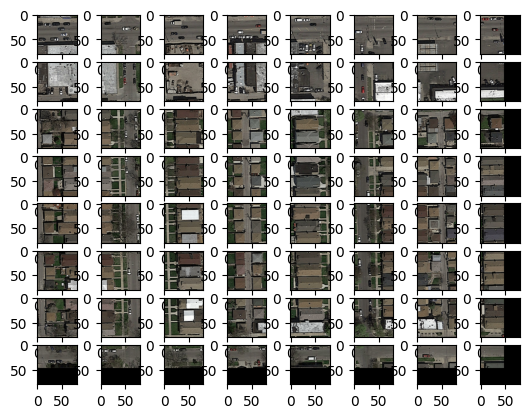

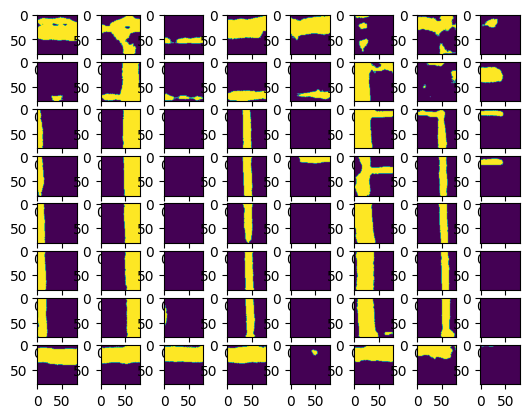

In [11]:
# Look at the prediction for the first image
fig, ax = plt.subplots(8,8) # Works for patchsize = 80
for i in range(8):
    for j in range(8):
        ax[i,j].imshow(X_test[8*i + j])
fig1, ax1 = plt.subplots(8,8) # Works for patchsize = 80
for i in range(8):
    for j in range(8):
        ax1[i,j].imshow(np.squeeze(preds_test_t[8*i + j]))

In [20]:
submission = []
# The constants with _SIDE mean how many patches fit per image in one dimension (one side)
TEST_IMAGE_LENGTH = 608
PATCHES_PER_IMAGE_SIDE = math.ceil(TEST_IMAGE_LENGTH/PATCH_SIZE)
PATCHES_PER_IMAGE = PATCHES_PER_IMAGE_SIDE**2
SUBIMAGES_PER_PATCH_SIDE = PATCH_SIZE/16
for i, pred in enumerate(preds_test):
    img_id = test_ids[i//PATCHES_PER_IMAGE]
    # Format the image id
    id = img_id.split('_')[1].zfill(3)
    # Make sure the patch size is a multiple of 16 otherwise this line won't work
    preds = helpers.split_into_patches(pred, 16)
    for j, img in enumerate(preds):
        # Calculate the index of each subimage (in terms of pixels)
        x = 16*(SUBIMAGES_PER_PATCH_SIDE*((i % PATCHES_PER_IMAGE) % PATCHES_PER_IMAGE_SIDE) + j % SUBIMAGES_PER_PATCH_SIDE)
        y = 16*(SUBIMAGES_PER_PATCH_SIDE*((i % PATCHES_PER_IMAGE) // PATCHES_PER_IMAGE_SIDE) + j // SUBIMAGES_PER_PATCH_SIDE)
        # Don't add the padding predictions
        if x < TEST_IMAGE_LENGTH and y < TEST_IMAGE_LENGTH:
            # For now we calculate the average over all the pixels and check if it's above 0.5
            submission.append((f"{id}_{x:.0f}_{y:.0f}", 1 if img.mean() > 0.5 else 0))
np.savetxt("predictions.csv", np.asarray(submission), fmt="%s", delimiter=",", newline="\n", header="id,prediction", comments="")